[![Open In Colab](./images/colab-badge.png)](https://colab.research.google.com/github/abrsvn/pyactr-book/blob/master/notebooks/29_exponential_model_of_forgetting.ipynb)

The code so far:

In [1]:
# loading the data
import pandas as pd

url = 'https://github.com/abrsvn/pyactr-book/blob/master/data/ebbinghaus_retention_data.csv?raw=true'
ebbinghaus_data = pd.read_csv(url)
ebbinghaus_data

,delay_in_hours,percent_savings
0,0.33,58.2
1,1.00,44.2
2,8.80,35.8
3,24.00,33.7
4,48.00,27.8
5,144.00,25.4
6,744.00,21.1


In [2]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 400
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import seaborn as sns

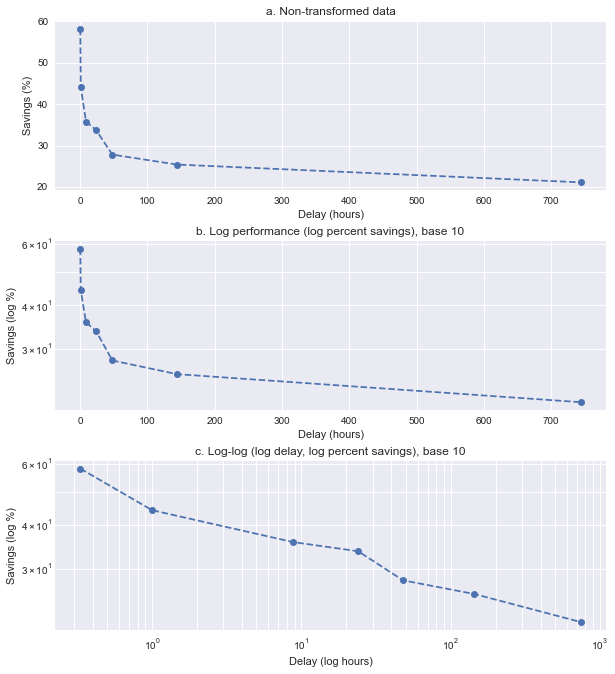

In [3]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=1, nrows=3)
fig.set_size_inches(8.5, 9.3)

# plot 1
ax1.plot(ebbinghaus_data['delay_in_hours'],
         ebbinghaus_data['percent_savings'],
         marker='o', linestyle='--')
ax1.set_title('a. Non-transformed data')
ax1.set_xlabel('Delay (hours)')
ax1.set_ylabel('Savings (%)')

# plot 2
ax2.plot(ebbinghaus_data['delay_in_hours'],
        ebbinghaus_data['percent_savings'],
        marker='o', linestyle='--')
ax2.set_title('b. Log performance (log percent savings), base 10')
ax2.set_xlabel('Delay (hours)')
ax2.set_ylabel('Savings (log %)')
ax2.set_yscale('log', base=10)
ax2.grid(b=True, which='minor', color='w', linewidth=1.0)

# plot 3
ax3.plot(ebbinghaus_data['delay_in_hours'],
        ebbinghaus_data['percent_savings'],
        marker='o', linestyle='--')
ax3.set_title('c. Log-log (log delay, log percent savings), base 10')
ax3.set_xlabel('Delay (log hours)')
ax3.set_xscale('log', base=10)
ax3.set_ylabel('Savings (log %)')
ax3.set_yscale('log', base=10)
ax3.grid(b=True, which='minor', color='w', linewidth=1.0)
# clean up
plt.tight_layout(pad=0.5, w_pad=0.2, h_pad=0.7)

In [4]:
import numpy as np

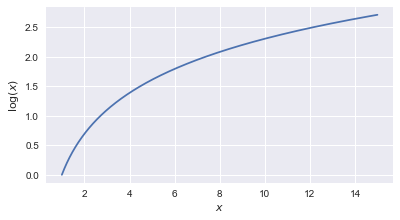

In [5]:
fig, ax = plt.subplots(ncols=1, nrows=1)
fig.set_size_inches(5.5, 3)
x = np.arange(1, 15, 0.01)
ax.plot(x, np.log(x), linestyle='-')
#ax.set_xlim(left=1)
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$\log(x)$')
plt.tight_layout(pad=0.5, w_pad=0.2, h_pad=0.7)

## The exponential model of forgetting

The idea behind the exponential model of forgetting:

- once we logarithmically compress performance, log performance will be a linear function of time

However, panel (b) of the Ebbinghaus data plots above shows that this is not the case:

- the relationship between the delay on the $x$-axis, measured in hours, and savings on the $y$-axis, measured in log-transformed percentages, is still not linear

We can use our recently acquired knowledge of Bayesian modeling with ```pymc3``` to compare the actual observations and the predictions made by a theory that hypothesizes that performance (forgetting) is an exponential function of time.

- in the code below, we import the relevant libraries and then store the ```delay``` and ```savings``` data in separate variables for convenience (lines 1-6)
- we then write up the exponential model directly from the equation we had in the previous notebook:
    - $\log(P) = \log(\alpha) - \beta T$
    - the likelihood function defined on lines 15-17 below says that log savings (i.e., log performance) is a linear function of ```delay``` 
        - with two free parameters ```intercept``` and ```slope```, plus some normally distributed noise with standard deviation ```sigma```

The hypothesis that log savings are a linear function of delay is tantamount to saying that, if we plot the mean ```mu``` of log savings for any given delay, we obtain a line.

A line is standardly characterized in terms of an intercept and a slope (line 15: ```mu``` is a deterministic function of delay, given parameters ```intercept``` and ```slope```).

- the intercept corresponds to $\log(\alpha)$ in the formula above
- the slope corresponds to $-\beta$.

Lines 11-13 in the exponential model provide low information priors for the intercept, slope, and noise. 

- the priors have familiar forms; we set the standard deviations for all priors to $100$, which is very non-committal since the response / dependent variable is measured in log-percent units

Once the priors and likelihood are specified, we can run the model and save the result in the variable ```trace```.

In [6]:
import pymc3 as pm

delay = ebbinghaus_data['delay_in_hours']
savings = ebbinghaus_data['percent_savings']

exponential_model = pm.Model()

In [7]:
with exponential_model:
    # priors
    intercept = pm.Normal('intercept', mu=0, sd=100)
    slope = pm.Normal('slope', mu=0, sd=100)
    sigma = pm.HalfNormal('sigma', sd=100)
    # likelihood
    mu = pm.Deterministic('mu', intercept + slope*delay)
    log_savings = pm.Normal('log_savings', mu=mu, sd=sigma,
                            observed=np.log(savings))

with exponential_model:
    trace = pm.sample(draws=5000, tune=50000, cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, slope, intercept]


Sampling 4 chains for 50_000 tune and 5_000 draw iterations (200_000 + 20_000 draws total) took 38 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 156 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.43265973495296695, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


With the posterior distributions for our exponential model in hand, we can compare the predictions made by the model against the actual data to see how close the predictions are.

- the predictions are stored in the variable ```mu```
- these are predicted log savings
- if we exponentiate them, we obtain predicted savings
- if we look at the $95\%$ credible intervals for the predicted savings, we can see the range of predictive variability / uncertainty in the predictions made by the exponential model
- if the actual savings fall within these credible intervals, we can take the model to be empirically adequate
- the code below generates two plots that enable us to empirically evaluate the exponential model

In [8]:
mu = trace["mu"]
mu.shape

(20000, 7)

In [9]:
import arviz as az

/usr/local/lib/python3.8/dist-packages/arviz/stats/stats.py:493: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


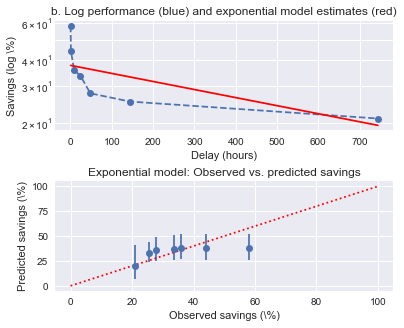

In [10]:
fig, (ax1, ax2) = plt.subplots(ncols=1, nrows=2)
fig.set_size_inches(5.5, 4.5)

# plot 1
ax1.plot(delay, savings, marker='o', linestyle='--')
ax1.plot(delay, np.exp(mu.mean(axis=0)), color='red', linestyle='-')
ax1.set_title('b. Log performance (blue) and exponential model estimates (red)')
ax1.set_xlabel('Delay (hours)')
ax1.set_ylabel('Savings (log \\%)')
ax1.set_yscale('log', base=10)
ax1.grid(b=True, which='minor', color='w', linewidth=1.0)

# plot 2
yerr=[np.median(np.exp(mu), axis=0)-az.hdi(np.exp(mu))[:,0],
      np.exp(az.hdi(mu)[:,1])-np.exp(mu.mean(axis=0))]
ax2.errorbar(savings, np.median(np.exp(mu), axis=0), yerr=yerr,
             marker='o', linestyle='')
ax2.plot(np.linspace(0, 100, 10), np.linspace(0, 100, 10),\
         color='red', linestyle=':')
ax2.set_title('Exponential model: Observed vs. predicted savings')
ax2.set_xlabel('Observed savings (\\%)')
ax2.set_ylabel('Predicted savings (\\%)')
ax2.grid(b=True, which='minor', color='w', linewidth=1.0)

# clean up and save
plt.tight_layout(pad=0.5, w_pad=0.2, h_pad=0.7)

The plot in the top panel reproduces the middle panel of our previous Ebbinghaus data plot, together with the line of best fit predicted by the exponential model
- it is clear that the line does not match the actual data very well.

This lack of empirical adequacy is also visible in the second plot of the figure above, which plots the percent savings predicted by the exponential model on the $y$-axis against the observed percent savings on the $x$-axis.
- the red diagonal line indicates the points where the predictions would be exactly equal to the observed values
- we see that the mean predicted savings are not very close to the observed values, especially for higher savings (associated with a short delay):
    - some of the points are pretty far from the diagonal line
    - some of the $95\%$ intervals do not cross the diagonal line at all, or barely cross it
- the fact that the points are pretty far from the diagonal line indicates that the exponential model makes incorrect predictions
- the fact that some of the $95\%$ intervals around those mean predictions do not cross the diagonal line, or barely cross it, indicates that the exponential model is not only wrong, but it is also pretty confident about some of its incorrect predictions

We can now confidently conclude that memory performance (forgetting) is not a negative exponential function of time.